In [1]:
import uproot
import awkward as ak
from coffea import nanoevents
from coffea.nanoevents.methods.base import NanoEventsArray
from coffea.analysis_tools import Weights, PackedSelection
from coffea.nanoevents.methods import nanoaod
from coffea.nanoevents.methods import vector
from coffea.lookup_tools.dense_lookup import dense_lookup
from coffea.nanoevents.methods.nanoaod import MuonArray, JetArray, FatJetArray, GenParticleArray

ak.behavior.update(vector.behavior)

import pickle, json, gzip
import numpy as np

from typing import Optional, List, Dict, Tuple
from copy import copy

import matplotlib.pyplot as plt
import mplhep as hep
from matplotlib import colors

from tqdm import tqdm

# import fastjet

import pathlib

# import jetnet

import os

import corrections
import correctionlib

from utils import P4

Failed loading compiled JECs


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plot_dir = "../../../plots/ScaleFactors/Feb1"
_ = os.system(f"mkdir -p {plot_dir}")

In [4]:
events = nanoevents.NanoEventsFactory.from_root(
    # "/eos/uscms/store/user/lpcpfnano/cmantill/v2_3/2017/HH_gen/GluGluToHHTobbVV_node_cHHH1_TuneCP5_13TeV-powheg-pythia8/GluGluToHHTobbVV_node_cHHH1/221017_221918/0000/nano_mc2017_100.root",
    "/eos/uscms//store/user/lpcpfnano/rkansal/v2_3/2016APV/XHY/NMSSM_XToYHTo2W2BTo4Q2B_MX-3000_MY-190_TuneCP5_13TeV-madgraph-pythia8/NMSSM_XToYHTo2W2BTo4Q2B_MX-3000_MY-190/230323_173705/0000/nano_mc2016pre_13.root",
    # "../../../../data/2017_UL_nano/NMSSM_XToYH_MX1000_MY400_HTo2bYTo2W_hadronicDecay/nano_mc2017_101.root",
    schemaclass=nanoevents.NanoAODSchema,
).events()

/uscms_data/d3/rkansal/mambaforge/envs/python39/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15SubJet_nBHadrons in <TTree 'Events' (1813 branches) at 0x7f9ce407a790>, taking first instance
  warnings.warn(
/uscms_data/d3/rkansal/mambaforge/envs/python39/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15SubJet_nCHadrons in <TTree 'Events' (1813 branches) at 0x7f9ce407a790>, taking first instance
  warnings.warn(
/uscms_data/d3/rkansal/mambaforge/envs/python39/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15_nBHadrons in <TTree 'Events' (1813 branches) at 0x7f9ce407a790>, taking first instance
  warnings.warn(
/uscms_data/d3/rkansal/mambaforge/envs/python39/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15_nCHadrons in <TTree 'Eve

### HHbbVV Pre-selection

In [5]:
def pad_val(
    arr: ak.Array,
    target: int,
    value: float,
    axis: int = 0,
    to_numpy: bool = True,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=axis)
    return ret.to_numpy() if to_numpy else ret


def add_selection(
    name: str,
    sel: np.ndarray,
    selection: PackedSelection,
    cutflow: dict = None,
    isData: bool = False,
    signGenWeights: ak.Array = None,
):
    """adds selection to PackedSelection object and the cutflow dictionary"""
    selection.add(name, sel)
    if cutflow is not None:
        cutflow[name] = (
            np.sum(selection.all(*selection.names))
            if isData
            # add up sign of genWeights for MC
            else np.sum(signGenWeights[selection.all(*selection.names)])
        )

In [7]:
isData = False
signGenWeights = None if isData else np.sign(events["genWeight"])
n_events = len(events) if isData else int(np.sum(signGenWeights))
selection = PackedSelection()

cutflow = {}
cutflow["all"] = len(events)

preselection_cut_vals = {"pt": 250, "msd": 20}
num_jets = 2

# fatjets = corrections.get_jec_jets(events, "2018")
fatjets = events.FatJet

preselection_cut = np.prod(
    pad_val(
        (events.FatJet.pt > preselection_cut_vals["pt"])
        * (events.FatJet.msoftdrop > preselection_cut_vals["msd"]),
        num_jets,
        False,
        axis=1,
    ),
    axis=1,
)

add_selection(
    "preselection",
    preselection_cut.astype(bool),
    selection,
    cutflow,
    isData,
    signGenWeights,
)

### Gen Matching

In [9]:
d_PDGID = 1
u_PDGID = 2
s_PDGID = 3
c_PDGID = 4
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25
Y_PDGID = 35

b_PDGIDS = [511, 521, 523]

GRAV_PDGID = 39

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

FILL_NONE_VALUE = -99999
PAD_VAL = -99999

skim_vars = {
    "eta": "Eta",
    "phi": "Phi",
    "mass": "Mass",
    "pt": "Pt",
}

Nonresonant

In [ ]:
# finding the two gen higgs
higgs = events.GenPart[
    (abs(events.GenPart.pdgId) == HIGGS_PDGID) * events.GenPart.hasFlags(GEN_FLAGS)
]

# saving 4-vector info
GenHiggsVars = {f"GenHiggs{key}": higgs[var].to_numpy() for (var, key) in skim_vars.items()}

higgs_children = higgs.children

# saving whether H->bb or H->VV
GenHiggsVars["GenHiggsChildren"] = abs(higgs_children.pdgId[:, :, 0]).to_numpy()

# finding bb and VV children
is_bb = abs(higgs_children.pdgId) == b_PDGID
is_VV = (abs(higgs_children.pdgId) == W_PDGID) + (abs(higgs_children.pdgId) == Z_PDGID)

Hbb = higgs[ak.sum(is_bb, axis=2) == 2]
HVV = higgs[ak.sum(is_VV, axis=2) == 2]

# checking that there are 2 b's and 2 V's
has_bb = ak.sum(ak.flatten(is_bb, axis=2), axis=1) == 2
has_VV = ak.sum(ak.flatten(is_VV, axis=2), axis=1) == 2

# only select events with 2 b's and 2 V's
add_selection("has_bbVV", has_bb * has_VV, selection, cutflow, False, signGenWeights)

# saving bb and VV 4-vector info
bb = ak.flatten(higgs_children[is_bb], axis=2)
VV = ak.flatten(higgs_children[is_VV], axis=2)

# have to pad to 2 because of some 4V events
GenbbVars = {
    f"Genbb{key}": pad_val(bb[var], 2, FILL_NONE_VALUE, axis=1) for (var, key) in skim_vars.items()
}

# selecting only up to the 2nd index because of some 4V events
# (doesn't matter which two are selected since these events will be excluded anyway)
GenVVVars = {f"GenVV{key}": VV[var][:, :2].to_numpy() for (var, key) in skim_vars.items()}

# checking that each V has 2 q children
VV_children = VV.children

quarks = abs(VV_children.pdgId) <= b_PDGID
all_q = ak.all(ak.all(quarks, axis=2), axis=1)
add_selection("all_q", all_q, selection, cutflow, False, signGenWeights)

V_has_2q = ak.count(VV_children.pdgId, axis=2) == 2
has_4q = ak.values_astype(ak.prod(V_has_2q, axis=1), np.bool)
add_selection("has_4q", has_4q, selection, cutflow, False, signGenWeights)

# saving 4q 4-vector info
Gen4qVars = {
    f"Gen4q{key}": ak.to_numpy(
        ak.fill_none(
            ak.pad_none(ak.pad_none(VV_children[var], 2, axis=1, clip=True), 2, axis=2, clip=True),
            FILL_NONE_VALUE,
        )
    )
    for (var, key) in skim_vars.items()
}

Resonant

In [13]:
# gen higgs and kids
higgs = events.GenPart[
    (abs(events.GenPart.pdgId) == HIGGS_PDGID) * events.GenPart.hasFlags(GEN_FLAGS)
]
GenHiggsVars = {f"GenHiggs{key}": higgs[var].to_numpy() for (var, key) in skim_vars.items()}
is_bb = abs(higgs.children.pdgId) == b_PDGID
has_bb = ak.sum(ak.flatten(is_bb, axis=2), axis=1) == 2

bb = ak.flatten(higgs.children[is_bb], axis=2)
# GenbbVars = {f"Genbb{key}": pad_val(bb[var], 2, axis=1) for (var, key) in skim_vars.items()}

# gen Y and kids
Ys = events.GenPart[(abs(events.GenPart.pdgId) == Y_PDGID) * events.GenPart.hasFlags(GEN_FLAGS)]
GenYVars = {f"GenY{key}": Ys[var].to_numpy() for (var, key) in skim_vars.items()}
is_VV = (abs(Ys.children.pdgId) == W_PDGID) + (abs(Ys.children.pdgId) == Z_PDGID)
has_VV = ak.sum(ak.flatten(is_VV, axis=2), axis=1) == 2

add_selection("has_bbVV", has_bb * has_VV, selection, cutflow, False, signGenWeights)

VV = ak.flatten(Ys.children[is_VV], axis=2)
# GenVVVars = {f"GenVV{key}": VV[var][:, :2].to_numpy() for (var, key) in skim_vars.items()}

VV_children = VV.children
quarks = abs(VV_children.pdgId) <= b_PDGID
all_q = ak.all(ak.all(quarks, axis=2), axis=1)
add_selection("all_q", all_q, selection, cutflow, False, signGenWeights)

V_has_2q = ak.count(VV_children.pdgId, axis=2) == 2
has_4q = ak.values_astype(ak.prod(V_has_2q, axis=1), bool)
add_selection("has_4q", has_4q, selection, cutflow, False, signGenWeights)

# Gen4qVars = {
#     f"Gen4q{key}": ak.to_numpy(
#         ak.fill_none(
#             ak.pad_none(
#                 ak.pad_none(VV_children[var], 2, axis=1, clip=True), 2, axis=2, clip=True
#             ),
#             PAD_VAL,
#         )
#     )
#     for (var, key) in skim_vars.items()
# }

# fatjet gen matching
Hbb = ak.pad_none(higgs, 1, axis=1, clip=True)[:, 0]
HVV = ak.pad_none(Ys, 1, axis=1, clip=True)[:, 0]

bbdr = fatjets[:, :2].delta_r(Hbb)
vvdr = fatjets[:, :2].delta_r(HVV)

match_dR = 0.8
Hbb_match = bbdr <= match_dR
HVV_match = vvdr <= match_dR

# overlap removal - in the case where fatjet is matched to both, match it only to the closest Higgs
Hbb_match = (Hbb_match * ~HVV_match) + (bbdr <= vvdr) * (Hbb_match * HVV_match)
HVV_match = (HVV_match * ~Hbb_match) + (bbdr > vvdr) * (Hbb_match * HVV_match)

VVJets = ak.pad_none(fatjets[HVV_match], 1, axis=1)[:, 0]
quarkdrs = ak.flatten(VVJets.delta_r(VV_children), axis=2)
num_prongs = ak.sum(quarkdrs < match_dR, axis=1)

# GenMatchingVars = {
#     "ak8FatJetHbb": pad_val(Hbb_match, 2, axis=1),
#     "ak8FatJetHVV": pad_val(HVV_match, 2, axis=1),
#     "ak8FatJetHVVNumProngs": ak.fill_none(num_prongs, PAD_VAL).to_numpy(),
# }

(array([410., 410., 390., 390.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 178.,
          0., 356.]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5]),
 [<matplotlib.patches.Polygon at 0x7fd7b954ab00>])

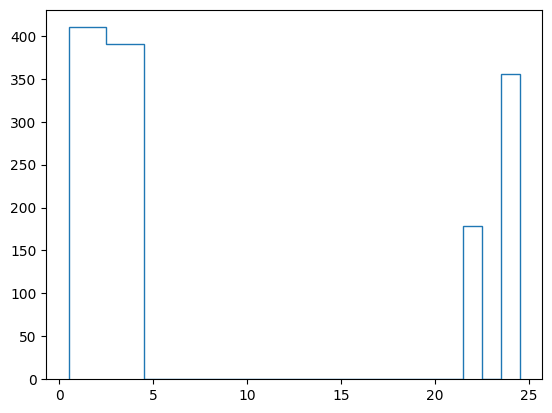

In [67]:
plt.hist(
    np.abs(ak.flatten(ak.flatten(ak.flatten(Ys.distinctChildren.children.pdgId)))),
    np.linspace(0.5, 24.5, 25),
    histtype="step",
)

(array([358., 118.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  87.]),
 array([ 1. ,  3.3,  5.6,  7.9, 10.2, 12.5, 14.8, 17.1, 19.4, 21.7, 24. ]),
 <BarContainer object of 10 artists>)

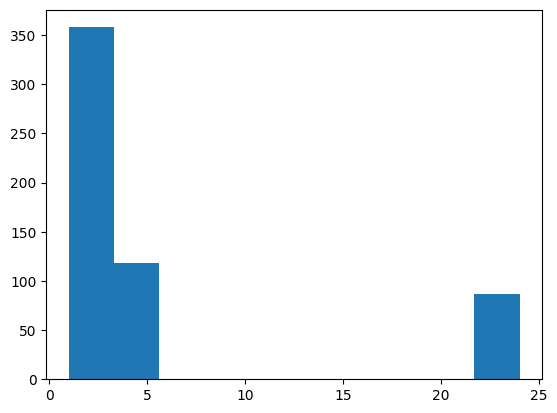

In [52]:
plt.hist(
    np.abs(
        ak.flatten(
            ak.flatten(ak.flatten(VV.children[np.abs(VV.children.pdgId) > 5].children.pdgId))
        )
    )
)

(array([148.,   0.,   0.,   0., 504., 504.,   0.,   0.,   0., 296.]),
 array([-24. , -19.2, -14.4,  -9.6,  -4.8,   0. ,   4.8,   9.6,  14.4,
         19.2,  24. ]),
 <BarContainer object of 10 artists>)

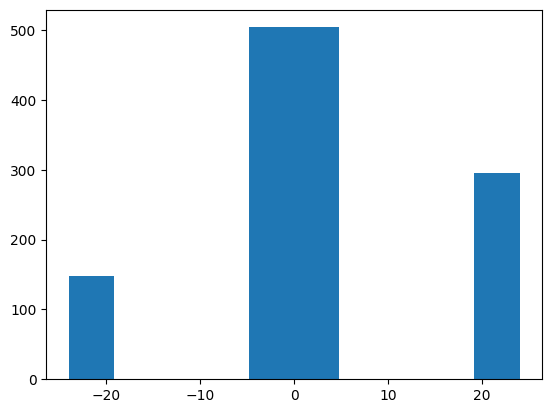

In [32]:
plt.hist(ak.flatten(ak.flatten(VV.children.pdgId, axis=1)))

In [40]:
ak.any(np.abs(ddYs.distinctChildren.children.pdgId) > 5)

True

(array([  0., 514., 527., 506., 501.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        148.,   0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]),
 [<matplotlib.patches.Polygon at 0x7fd7b927dba0>])

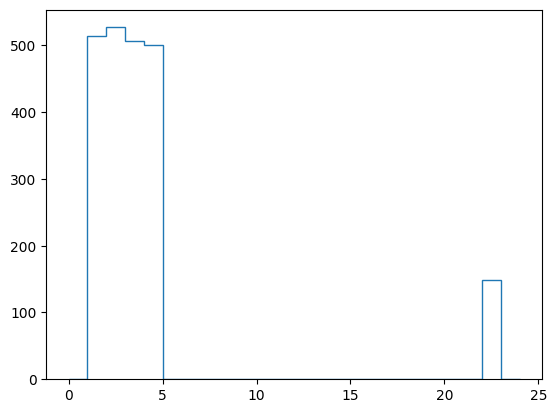

In [34]:
plt.hist(
    np.abs(ak.flatten(ak.flatten(VV.distinctChildren.pdgId, axis=1))),
    np.linspace(0, 24, 25),
    histtype="step",
)

In [58]:
Ys.children.fields

['eta',
 'mass',
 'phi',
 'pt',
 'genPartIdxMother',
 'pdgId',
 'status',
 'statusFlags',
 'genPartIdxMotherG',
 'distinctParentIdxG',
 'childrenIdxG',
 'distinctChildrenIdxG']

In [ ]:
select = selection.all(*selection.names)
presel_events = events[selection.all(*selection.names)]

In [ ]:
Hbb = higgs[ak.sum(is_bb, axis=2) == 2]
HVV = higgs[ak.sum(is_VV, axis=2) == 2]

Hbb = ak.pad_none(Hbb, 1, axis=1, clip=True)[:, 0]
HVV = ak.pad_none(HVV, 1, axis=1, clip=True)[:, 0]

In [ ]:
bbdr = fatjets[:, :2].delta_r(Hbb)
vvdr = fatjets[:, :2].delta_r(HVV)

In [ ]:
_ = plt.hist(np.array(bbdr[select]).reshape(-1), np.linspace(0, 5, 101), histtype="step")

In [ ]:
_ = plt.hist(np.array(vvdr[select]).reshape(-1), np.linspace(0, 5, 101), histtype="step")

In [ ]:
match_dR = 0.8
Hbb_match = bbdr <= match_dR
HVV_match = vvdr <= match_dR

# overlap removal - in the case where fatjet is matched to both, match it only to the closest Higgs
Hbb_match = (Hbb_match * ~HVV_match) + (bbdr <= vvdr) * (Hbb_match * HVV_match)
HVV_match = (HVV_match * ~Hbb_match) + (bbdr > vvdr) * (Hbb_match * HVV_match)

In [ ]:
Hbb_match

In [ ]:
VVJets = ak.pad_none(fatjets[HVV_match], 1, axis=1)[:, 0]
quarkdrs = ak.flatten(VVJets.delta_r(VV_children), axis=2)
num_prongs = ak.sum(quarkdrs < match_dR, axis=1)

In [ ]:
genbb, genq = (bb, ak.flatten(VV_children, axis=2))

In [ ]:
GenMatchingVars = {
    "ak8FatJetHbb": pad_val(ak.fill_none(Hbb_match, [], axis=0), 2, FILL_NONE_VALUE, axis=1),
    "ak8FatJetHVV": pad_val(ak.fill_none(HVV_match, [], axis=0), 2, FILL_NONE_VALUE, axis=1),
    "ak8FatJetHVVNumProngs": ak.fill_none(num_prongs, -99999).to_numpy(),
}

In [ ]:
skimmed_events = {key: val[select] for key, val in GenMatchingVars.items()}

In [ ]:
# jet definitions for LP SFs
dR = 0.8
cadef = fastjet.JetDefinition(fastjet.cambridge_algorithm, dR)
ktdef = fastjet.JetDefinition(fastjet.kt_algorithm, dR)
n_LP_sf_toys = 100

package_path = "../"


def _get_lund_arrays(events: NanoEventsArray, fatjet_idx: Union[int, ak.Array], num_prongs: int):
    """
    Gets the ``num_prongs`` subjet pTs and Delta and kT per primary LP splitting of fatjets at
    ``fatjet_idx`` in each event.

    Features are flattened (for now), and offsets are saved in ``ld_offsets`` to recover the event
    structure.

    Args:
        events (NanoEventsArray): nano events
        fatjet_idx (int | ak.Array): fatjet index
        num_prongs (int): number of prongs / subjets per jet to reweight

    Returns:
        flat_logD, flat_logkt, flat_subjet_pt, ld_offsets, kt_subjets_vec
    """

    # get pfcands of the top-matched jets
    ak8_pfcands = events.FatJetPFCands
    ak8_pfcands = ak8_pfcands[ak8_pfcands.jetIdx == fatjet_idx]
    pfcands = events.PFCands[ak8_pfcands.pFCandsIdx]

    # need to convert to such a structure for FastJet
    pfcands_vector_ptetaphi = ak.Array(
        [
            [{kin_key: cand[kin_key] for kin_key in P4} for cand in event_cands]
            for event_cands in pfcands
        ],
        with_name="PtEtaPhiMLorentzVector",
    )

    # cluster first with kT
    kt_clustering = fastjet.ClusterSequence(pfcands_vector_ptetaphi, ktdef)
    kt_subjets = kt_clustering.exclusive_jets(num_prongs)

    kt_subjets_vec = ak.zip(
        {"x": kt_subjets.px, "y": kt_subjets.py, "z": kt_subjets.pz, "t": kt_subjets.E},
        with_name="LorentzVector",
    )

    # save subjet pT
    kt_subjets_pt = kt_subjets_vec.pt
    # get constituents
    kt_subjet_consts = kt_clustering.exclusive_jets_constituents(num_prongs)

    # then re-cluster with CA
    # won't need to flatten once https://github.com/scikit-hep/fastjet/pull/145 is released
    ca_clustering = fastjet.ClusterSequence(ak.flatten(kt_subjet_consts, axis=1), cadef)
    lds = ak.flatten(ca_clustering.exclusive_jets_lund_declusterings(1), axis=1)

    # flatten and save offsets to unflatten afterwards
    ld_offsets = lds.kt.layout.offsets
    flat_logD = np.log(0.8 / ak.flatten(lds).Delta).to_numpy()
    flat_logkt = np.log(ak.flatten(lds).kt).to_numpy()
    # repeat subjet pt for each lund declustering
    flat_subjet_pt = np.repeat(ak.flatten(kt_subjets_pt), ak.count(lds.kt, axis=1)).to_numpy()

    return flat_logD, flat_logkt, flat_subjet_pt, ld_offsets, kt_subjets_vec


def _calc_lund_SFs(
    flat_logD: np.ndarray,
    flat_logkt: np.ndarray,
    flat_subjet_pt: np.ndarray,
    ld_offsets: ak.Array,
    num_prongs: int,
    ratio_lookups: List[dense_lookup],
) -> np.ndarray:
    """
    Calculates scale factors for jets based on splittings in the primary Lund Plane.

    Lookup tables should be binned in [subjet_pt, ln(0.8/Delta), ln(kT/GeV)].

    Returns nominal scale factors for each lookup table in the ``ratio_smeared_lookups`` list.

    Args:
        flat_logD, flat_logkt, flat_subjet_pt, ld_offsets: numpy arrays from the ``lund_arrays`` fn
        num_prongs (int): number of prongs / subjets per jet to reweight
        ratio_smeared_lookups (List[dense_lookup]): list of lookup tables with smeared values

    Returns:
        nd.ndarray: SF values per jet for each smearing, shape ``[n_jets, len(ratio_lookups)]``.
    """

    sf_vals = []
    # could be parallelised but not sure if memory / time trade-off is worth it
    for i, ratio_lookup in enumerate(ratio_lookups):
        ratio_vals = ratio_lookup(flat_subjet_pt, flat_logD, flat_logkt)
        # recover jagged event structure
        reshaped_ratio_vals = ak.Array(
            ak.layout.ListOffsetArray64(ld_offsets, ak.layout.NumpyArray(ratio_vals))
        )
        # nominal values are product of all lund plane SFs
        sf_vals.append(
            # multiply subjet SFs per jet
            np.prod(
                # per-subjet SF
                ak.prod(reshaped_ratio_vals, axis=1).to_numpy().reshape(-1, num_prongs),
                axis=1,
            )
        )

    return np.array(sf_vals).T  # output shape: ``[n_jets, len(ratio_lookups)]``


def _get_lund_lookups(seed: int = 42, lnN: bool = True, trunc_gauss: bool = False):
    import uproot

    # initialize lund plane scale factors lookups
    f = uproot.open(package_path + "/corrections/lp_ratio_jan20.root")

    # 3D histogram: [subjet_pt, ln(0.8/Delta), ln(kT/GeV)]
    ratio_nom = f["ratio_nom"].to_numpy()
    ratio_nom_errs = f["ratio_nom"].errors()
    ratio_edges = ratio_nom[1:]
    ratio_nom = ratio_nom[0]

    ratio_sys_up = dense_lookup(f["ratio_sys_tot_up"].to_numpy()[0], ratio_edges)
    ratio_sys_down = dense_lookup(f["ratio_sys_tot_down"].to_numpy()[0], ratio_edges)

    np.random.seed(seed)
    rand_noise = np.random.normal(size=[n_LP_sf_toys, *ratio_nom.shape])

    if trunc_gauss:
        # produces array of shape ``[n_sf_toys, subjet_pt bins, ln(0.8/Delta) bins, ln(kT/GeV) bins]``
        ratio_nom_smeared = ratio_nom + (ratio_nom_errs * rand_noise)
        ratio_nom_smeared = np.maximum(ratio_nom_smeared, 0)
        # save n_sf_toys lookups
        ratio_smeared_lookups = [dense_lookup(ratio_nom, ratio_edges)] + [
            dense_lookup(ratio_nom_smeared[i], ratio_edges) for i in range(n_LP_sf_toys)
        ]
    else:
        ratio_smeared_lookups = None

    if lnN:
        # revised smearing (0s -> 1s, normal -> lnN)
        zero_noms = ratio_nom == 0
        ratio_nom[zero_noms] = 1
        ratio_nom_errs[zero_noms] = 0

        kappa = (ratio_nom + ratio_nom_errs) / ratio_nom
        ratio_nom_smeared = ratio_nom * np.power(kappa, rand_noise)
        ratio_lnN_smeared_lookups = [dense_lookup(ratio_nom, ratio_edges)] + [
            dense_lookup(ratio_nom_smeared[i], ratio_edges) for i in range(n_LP_sf_toys)
        ]
    else:
        ratio_lnN_smeared_lookups = None

    return ratio_smeared_lookups, ratio_lnN_smeared_lookups, ratio_sys_up, ratio_sys_down


(
    ratio_smeared_lookups,
    ratio_lnN_smeared_lookups,
    ratio_sys_up,
    ratio_sys_down,
) = (
    [],
    [],
    [],
    [],
)


def get_lund_SFs(
    events: NanoEventsArray,
    fatjet_idx: Union[int, ak.Array],
    num_prongs: int,
    gen_quarks: GenParticleArray,
    seed: int = 42,
    trunc_gauss: bool = False,
    lnN: bool = True,
) -> Dict[str, np.ndarray]:
    """
    Calculates scale factors for jets based on splittings in the primary Lund Plane.
    Calculates random smearings for statistical uncertainties, total up/down systematic variation,
    and subjet matching and pT extrapolation systematic uncertainties.

    Args:
        events (NanoEventsArray): nano events
        fatjet_idx (int | ak.Array): fatjet index
        num_prongs (int): number of prongs / subjets per jet to r
        seed (int, optional): seed for random smearings. Defaults to 42.
        trunc_gauss (bool, optional): use truncated gaussians for smearing. Defaults to False.
        lnN (bool, optional): use log normals for smearings. Defaults to True.

    Returns:
        Dict[str, np.ndarray]: dictionary with nominal weights per jet, sys variations, and (optionally) random smearings.
    """
    global ratio_smeared_lookups, ratio_lnN_smeared_lookups, ratio_sys_up, ratio_sys_down

    if (lnN and ratio_lnN_smeared_lookups == []) or (trunc_gauss and ratio_smeared_lookups == []):
        (
            ratio_smeared_lookups,
            ratio_lnN_smeared_lookups,
            ratio_sys_up,
            ratio_sys_down,
        ) = _get_lund_lookups(seed, lnN, trunc_gauss)

    print("ratio lnN smeared lookups")
    print(ratio_lnN_smeared_lookups[0]._values)

    flat_logD, flat_logkt, flat_subjet_pt, ld_offsets, kt_subjets_vec = _get_lund_arrays(
        events, fatjet_idx, num_prongs
    )

    sfs = {}

    ### get scale factors per jet + smearings for stat unc. + syst. variations

    if trunc_gauss:
        sfs["lp_sf"] = _calc_lund_SFs(
            flat_logD, flat_logkt, flat_subjet_pt, ld_offsets, num_prongs, ratio_smeared_lookups
        )

    if lnN:
        sfs["lp_sf_lnN"] = _calc_lund_SFs(
            flat_logD, flat_logkt, flat_subjet_pt, ld_offsets, num_prongs, ratio_lnN_smeared_lookups
        )

    sfs["lp_sf_sys_down"] = _calc_lund_SFs(
        flat_logD, flat_logkt, flat_subjet_pt, ld_offsets, num_prongs, [ratio_sys_down]
    )

    sfs["lp_sf_sys_up"] = _calc_lund_SFs(
        flat_logD, flat_logkt, flat_subjet_pt, ld_offsets, num_prongs, [ratio_sys_up]
    )

    ### subjet matching and pT extrapoation uncertainties

    matching_dR = 0.2
    sj_matched = []
    sj_matched_idx = []

    # get dR between gen quarks and subjets
    for i in range(num_prongs):
        sj_q_dr = kt_subjets_vec.delta_r(gen_quarks[:, i])
        # is quark matched to a subjet (dR < 0.2)
        sj_matched.append(ak.min(sj_q_dr, axis=1) <= matching_dR)
        # save index of closest subjet
        sj_matched_idx.append(ak.argmin(sj_q_dr, axis=1))

    sj_matched = np.array(sj_matched).T
    sj_matched_idx = np.array(sj_matched_idx).T

    # mask quarks which aren't matched to a subjet, to avoid overcounting events
    sj_matched_idx_mask = np.copy(sj_matched_idx)
    sj_matched_idx_mask[~sj_matched] = -1

    # events which have more than one quark matched to the same subjet
    sfs["lp_sf_double_matched_event"] = np.any(
        [np.sum(sj_matched_idx_mask == i, axis=1) > 1 for i in range(3)], axis=0
    ).astype(int)[:, np.newaxis]

    # number of quarks per event which aren't matched
    sfs["lp_sf_unmatched_quarks"] = np.sum(~sj_matched, axis=1, keepdims=True)

    # pT extrapolation uncertainty
    sfs["lp_sf_num_sjpt_gt350"] = np.sum(kt_subjets_vec.pt > 350, axis=1, keepdims=True).to_numpy()

    return sfs

In [ ]:
ratio_lnN_smeared_lookups

In [ ]:
# genbb = genbb[select]
# genq = genq[select]

i = 0

fatjetsi = fatjets[select][:, i]
bb_select = skimmed_events["ak8FatJetHbb"][:, i].astype(bool)
VV_select = skimmed_events["ak8FatJetHVV"][:, i].astype(bool)

# selectors for Hbb jets and HVV jets with 2, 3, or 4 prongs separately
selectors = {
    # name: (selector, gen quarks, num prongs)
    "bb": (bb_select, genbb, 2),
    **{
        f"VV{k}q": (VV_select * (skimmed_events["ak8FatJetHVVNumProngs"] == k), genq, k)
        for k in range(2, 4 + 1)
    },
}

selected_sfs = {}

for key, (selector, gen_quarks, num_prongs) in selectors.items():
    selected_sfs[key] = get_lund_SFs(
        events[select][selector],
        i,
        num_prongs,
        gen_quarks[selector],
        trunc_gauss=False,
        lnN=True,
    )

sf_dict = {}

# collect all the scale factors, fill in 0s for unmatched jets
for key, val in selected_sfs["bb"].items():
    arr = np.zeros((np.sum(select), val.shape[1]))

    for select_key, (selector, _, _) in selectors.items():
        arr[selector] = selected_sfs[select_key][key]

    sf_dict[key] = arr

In [ ]:
sf_dict = {}

# collect all the scale factors, fill in 0s for unmatched jets
for key, val in selected_sfs["bb"].items():
    arr = np.zeros((np.sum(select), val.shape[1]))

    for select_key, (selector, _, _) in selectors.items():
        arr[selector] = selected_sfs[select_key][key]

    sf_dict[key] = arr

In [ ]:
sf_dict["lp_sf_lnN"][VV_select * (skimmed_events["ak8FatJetHVVNumProngs"] == 2)]

In [ ]:
selected_sfs["VV2q"]["lp_sf_lnN"]

In [ ]:
selected_sfs

In [ ]:
arr[selector]

In [ ]:
selector

In [ ]:
skimmed_events["ak8FatJetHVVNumProngs"]

In [ ]:
np.sum(bb_select) + np.sum(VV_select)

In [ ]:
np.sum(VV_select)

In [ ]:
jet_idx = 0

ak8_pfcands = presel_events.FatJetPFCands
ak8_pfcands = ak8_pfcands[ak8_pfcands.jetIdx == jet_idx]
pfcands = presel_events.PFCands[ak8_pfcands.pFCandsIdx]

pfcands_vector_ptetaphi = ak.Array(
    [
        [{kin_key: cand[kin_key] for kin_key in skim_vars} for cand in event_cands]
        for event_cands in merged_pfcands
    ],
    with_name="PtEtaPhiMLorentzVector",
)